## Train RNNs to approximate point process filtering w/ RMSE and perform MVT according to results of filtering

In [1]:
import numpy as np
from numpy import random as rnd
import scipy.io as sio
from itertools import product
import seaborn as sns
import pandas as pd
import datetime
import pytz
import os

import torch
import torch.nn as nn
import torch.optim as optim

from matplotlib import pyplot as plt
from scipy.stats import zscore
import scipy.stats as stats

# from our files 
from tasks import PPSSM_FilteringTask
from models import RecurrentModel 
from visualizations import peaksort_vis_trial,forceAspect
from pp_init import pp_params,generate_from_rewtimes_y
from ppssm_utils import p_lessthan_x,stochastic_prt_gen
from model_init import model_params
from model_utils import save_model,load_model
from train import train


In [3]:
# model initialization
offdiag_val = 0.15
diag_val = 0.98
model_kwargs = model_params(offdiag_val = offdiag_val,diag_val = diag_val)
model_kwargs['reservoir_training'] = False 

# training initialization
n_batches = 3001
print_every = 100

# Training setup
point_process_type = "stochastic_foraging_session"
task = PPSSM_FilteringTask(pp_params(point_process_type),max_iter = n_batches)

model_kwargs['batch_size'] = task.batch_size
model = RecurrentModel(model_kwargs)

# Training parameters
param_l2_penalty = 1e-4 # (weight decay)
lr = 0.0005
grad_clip = 100
    
train_params = {
                    "tr_cond": 'high_gain',
                    "n_batches" : n_batches, 
                    "task" : task,
                    "model" : model, 
                    "param_l2_penalty" : param_l2_penalty,
                    "lr" : lr,
                    "grad_clip" : grad_clip,
                    "optimizer" : "adam",
                    "print_every" : print_every,
                    "performance_loss_fn" : "opt_s_rmse",
                    "regularization_loss_fn" : "zero_loss",    
                    }


In [5]:
# train model
trained_model,total_losses,performance_losses = train(**train_params)
save_model(trained_model,train_params)

Batch #0; Performance Loss: 2552254.866; Frac. RMSE: 1792310.528037; Opt. RMSE: 1.424002; Net. RMSE: 2552254.324884
Batch #100; Performance Loss: 430342496.106; Frac. RMSE: 2911693713.953021; Opt. RMSE: 1.460239; Net. RMSE: 4251768603.667811
Batch #200; Performance Loss: 0.876; Frac. RMSE: -0.133347; Opt. RMSE: 1.458516; Net. RMSE: 1.264027
Batch #300; Performance Loss: 0.678; Frac. RMSE: -0.081404; Opt. RMSE: 1.456572; Net. RMSE: 1.338001
Batch #400; Performance Loss: 0.519; Frac. RMSE: -0.030418; Opt. RMSE: 1.457915; Net. RMSE: 1.413568
Batch #500; Performance Loss: 0.425; Frac. RMSE: -0.017295; Opt. RMSE: 1.462874; Net. RMSE: 1.437574
Batch #600; Performance Loss: 0.341; Frac. RMSE: -0.008969; Opt. RMSE: 1.455999; Net. RMSE: 1.442941
Batch #700; Performance Loss: 0.305; Frac. RMSE: -0.003420; Opt. RMSE: 1.454941; Net. RMSE: 1.449965
Batch #800; Performance Loss: 0.283; Frac. RMSE: -0.002589; Opt. RMSE: 1.457206; Net. RMSE: 1.453432
Batch #900; Performance Loss: 0.271; Frac. RMSE: -0

In [3]:
# load a model
load_path = '/Users/joshstern/Documents/am231/FinalProject/runs/04_22/16_43_offdiag=0.15_diag=0.98_sigma2eps=0.04.pt'
trained_model,train_params = load_model(load_path)
performance_losses = train_params['performance_losses']


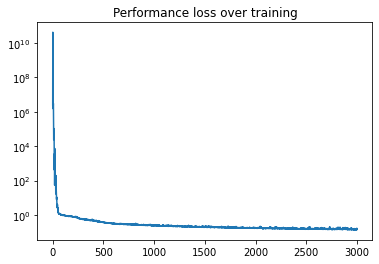

In [4]:
# plot losses
plt.plot(performance_losses)
plt.yscale("log")
plt.title("Performance loss over training"); 


In [5]:
# Now assess performance on test run
point_process_type = "stochastic_foraging_session"
test_task = PPSSM_FilteringTask(pp_params(point_process_type),max_iter = 1)

test_params = {
                "tr_cond": 'high_gain',
                "n_batches" : 1, 
                "task" : test_task,
                "model" : trained_model, 
                }


In [10]:
# test run
n_batches = 1 
test_task_params = pp_params("stochastic_foraging_session")
test_n_trials_per_tt = 10
test_task_params['generation_params']['n_trials_per_tt'] = test_n_trials_per_tt # incr number of trials 
test_task = PPSSM_FilteringTask(test_task_params,max_iter = n_batches)
trained_model.batch_size = test_task.batch_size

# Run model on test trials 
s_vec, opt_s_vec, ex_pred_vec, frac_rmse_vec = [], [], [], []
with torch.no_grad():
    for i, (example_input, example_output, opt_s , opt_s_sigma2) in test_task: # loop over batches in training set 
        output_dict = trained_model.forward(example_input) # perform forward pass
        

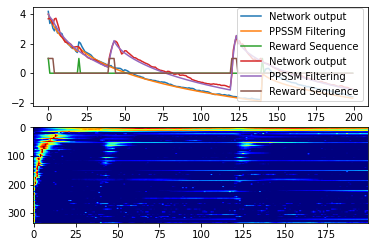

In [28]:
# Visualize example trial

vis_end_ix = 80
trial = 70
t_len = len(output_dict['readout_output'][trial,:,-1])
n_neurons = output_dict['core_output'][trial].shape[0]
fig,ax = plt.subplots(2,1)
for trial in [0,85]:
    ax[0].plot(output_dict['readout_output'][trial,:,-1].detach().numpy(),label = "Network output")
    ax[0].plot(opt_s[trial,:,-1],label = "PPSSM Filtering")
    ax[0].plot(example_output[trial,:,-1],label = 'Reward Sequence')
    ax[0].legend()

peaksort = peaksort_vis_trial(output_dict['core_output'][trial],ax = ax[1],vis_end_ix = None,sort_end_ix = 20,normalization = 'max')
aspect = 3.5 * t_len/n_neurons
forceAspect(ax[1],aspect)


Text(0.5, 1.0, 'RNN Point Process Filtering')

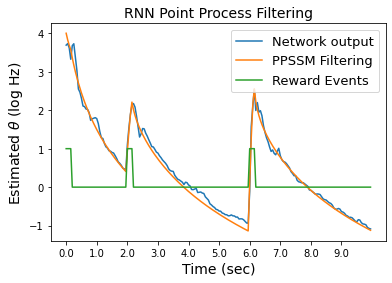

In [27]:
trial = 85
fig,ax = plt.subplots(1,1)
ax.plot(output_dict['readout_output'][trial,:,-1].detach().numpy(),label = "Network output")
ax.plot(opt_s[trial,:,-1],label = "PPSSM Filtering")
ax.plot(example_output[trial,:,-1],label = 'Reward Events')
ax.legend(fontsize = 13)
ax.set_xlabel("Time (sec)",fontsize = 14)
ax.set_xticks(np.arange(0,200,20))
ax.set_xticklabels(.05 * np.arange(0,200,20))
ax.set_ylabel(r"Estimated $\theta$ (log Hz)",fontsize = 14)
ax.set_title("RNN Point Process Filtering",fontsize = 14)

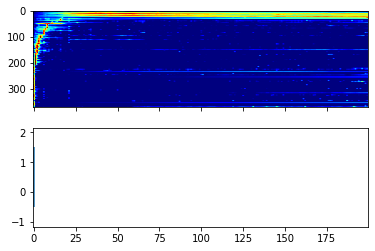

In [18]:
trial = 2
fig,ax = plt.subplots(2,1,sharex = True)
peaksort = peaksort_vis_trial(output_dict['core_output'][trial],ax = ax[0],sort_end_ix = 20,normalization = 'max')
aspect = 3.5 * t_len/n_neurons
forceAspect(ax[0],aspect)
ax[1].eventplot(np.where(example_output[trial] > 0))

In [16]:
# See what behavior looks like 
# reorganize output into tt dict
concatenated_output = output_dict['readout_output'].squeeze().numpy()
concatenated_opt_s = opt_s.squeeze()

concatenated_opt_s_sigma = np.zeros((concatenated_opt_s.shape[0],concatenated_opt_s.shape[1],2))
concatenated_opt_s_sigma[:,:,0] = opt_s.squeeze()
concatenated_opt_s_sigma[:,:,1] = opt_s_sigma2.squeeze()

ix_range = range(0,concatenated_output.shape[0]+test_n_trials_per_tt,test_n_trials_per_tt)
tts = test_task.y_generator(**test_task.ppssm_params['generation_params']).keys() 
theta_readout_tts = dict()
theta_opt_tts = dict()
for i,tt in enumerate(tts):
    theta_readout_tts[tt] = concatenated_output[ix_range[i]:ix_range[i+1],:]
    theta_opt_tts[tt] = concatenated_opt_s_sigma[ix_range[i]:ix_range[i+1],:,:]

In [17]:
lognorm_cdf = lambda x,theta,sigma2: stats.lognorm.cdf(x,s = np.sqrt(sigma2),scale = np.exp(theta))

def p_lessthan_x(ppssm_tts_trials,x,sigma2_fixed = None): 
    """ 
        Given PPSSM results for a session, map trials into P(lambda < x) using the lognormal CDF
    """
    p_lessthan_tts_trials = {}
    for tt in ppssm_tts_trials.keys(): 
        p_lessthan_tts_trials[tt] = np.zeros((ppssm_tts_trials[tt].shape[0],ppssm_tts_trials[tt].shape[1]))
        for i_trial in range(len(ppssm_tts_trials[tt])): 
            if sigma2_fixed == None:
                p_lessthan_tts_trials[tt][i_trial,:] = lognorm_cdf(x,ppssm_tts_trials[tt][i_trial,:,0],ppssm_tts_trials[tt][i_trial,:,1])
            else:
                p_lessthan_tts_trials[tt][i_trial,:] = lognorm_cdf(x,ppssm_tts_trials[tt][i_trial,:],sigma2_fixed)
    return p_lessthan_tts_trials

def stochastic_prt_gen(p_lessthan_tts_trials,prt_lock = None,dt = 0.05): 
    """ 
        Given p_lessthan_tts_trials, return stochastically generated patch residence times
        Using p_lessthan_tts_trials as p(leave)
        
        Add PRT lock to ensure that agent stays until x time
    """  
    prts = {}
    for i_tt,tt in enumerate(p_lessthan_tts_trials.keys()): 
        t_len = len(p_lessthan_tts_trials[tt][0])
        prts[tt] = np.zeros(len(p_lessthan_tts_trials[tt])) 
        for i_trial in range(len(prts[tt])): 
            leave_ix = np.where(rnd.random(t_len) - dt * p_lessthan_tts_trials[tt][i_trial,:] < 0)[0] 
            if prt_lock == None: 
                if len(leave_ix) > 0: 
                    prts[tt][i_trial] = dt * leave_ix[0]
                else: 
                    prts[tt][i_trial] = dt * t_len
            else: 
                if len(leave_ix) > 0: 
                    if len(leave_ix[leave_ix*dt > prt_lock[i_tt]]): # lock prt to min value per tt
                        prts[tt][i_trial] = dt * leave_ix[leave_ix*dt > prt_lock[i_tt]][0]
                    else: 
                        prts[tt][i_trial] = dt * t_len
                else: 
                    prts[tt][i_trial] = dt * t_len
    return prts

Text(0.5, 1.0, 'Filtering P(Leave)')

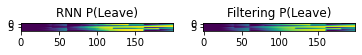

In [18]:
# Get p_leave
x = 1
sigma2_fixed = .25
net_p_lessthan_tts_trials = p_lessthan_x(theta_readout_tts,x,sigma2_fixed = sigma2_fixed)
opt_p_lessthan_tts_trials = p_lessthan_x(theta_opt_tts,x)
fig,ax = plt.subplots(1,2)
ax[0].imshow(net_p_lessthan_tts_trials[(4,0.5)])
ax[0].set_title("RNN P(Leave)")
ax[1].imshow(opt_p_lessthan_tts_trials[(4,0.5)])
ax[1].set_title("Filtering P(Leave)")


In [19]:
# Generate PRTs
prts_opt = stochastic_prt_gen(opt_p_lessthan_tts_trials)
prts_opt_df = pd.DataFrame.from_dict(prts_opt,orient = 'index').reset_index().melt(id_vars = 'index')
prts_opt_df = prts_opt_df.drop(['variable'],axis = 'columns')
prts_opt_df = prts_opt_df.rename(columns={"index": "tt", "value": "PRT"})

prts_net = stochastic_prt_gen(net_p_lessthan_tts_trials)
prts_net_df = pd.DataFrame.from_dict(prts_net,orient = 'index').reset_index().melt(id_vars = 'index')
prts_net_df = prts_net_df.drop(['variable'],axis = 'columns')
prts_net_df = prts_net_df.rename(columns={"index": "tt", "value": "PRT"})

Text(0.5, 1.0, 'RNN Behavior')

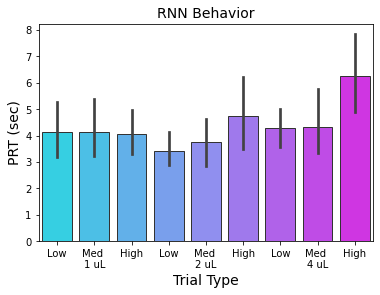

In [20]:
ax = sns.barplot(x="tt", y="PRT", data=prts_net_df,palette = 'cool',edgecolor="0.2")
ax.set_xticklabels(["Low","Med \n1 uL","High"] + ["Low","Med \n2 uL","High"] + ["Low","Med \n4 uL","High"]) 
ax.set_xlabel("Trial Type",fontsize = 14) 
ax.set_ylabel("PRT (sec)",fontsize = 14)
ax.set_title("RNN Behavior",fontsize = 14)

In [213]:
# Now perform same protocol for RXX trials
n_batches = 1 
test_task_params = pp_params("rewtimes_foraging_session")
test_n_trials_per_tt = 1000
test_task_params['generation_params']['rewseqs'] = [np.array([0,2]),np.array([0,1,2])] # incr number of trials 
test_task_params['generation_params']['n_trials_per_tt'] = test_n_trials_per_tt # incr number of trials 
test_task = PPSSM_FilteringTask(test_task_params,max_iter = n_batches)
trained_model.batch_size = test_task.batch_size
model_kwargs['batch_size'] = test_task.batch_size

# Run model on test trials 
s_vec, opt_s_vec, ex_pred_vec, frac_rmse_vec = [], [], [], []
with torch.no_grad():
    for i, (example_input, example_output, opt_s , opt_s_sigma2) in test_task: # loop over batches in training set 
        output_dict = trained_model.forward(example_input) # perform forward pass
        

In [214]:
# reorganize output into tt dict
concatenated_output = output_dict['readout_output'].squeeze().numpy()
concatenated_opt_s = opt_s.squeeze()

concatenated_opt_s_sigma = np.zeros((concatenated_opt_s.shape[0],concatenated_opt_s.shape[1],2))
concatenated_opt_s_sigma[:,:,0] = opt_s.squeeze()
concatenated_opt_s_sigma[:,:,1] = opt_s_sigma2.squeeze()

# Get p_leave
ix_range = range(0,concatenated_output.shape[0]+test_n_trials_per_tt,test_n_trials_per_tt)
tts = test_task.y_generator(**test_task.ppssm_params['generation_params']).keys() 
theta_readout_tts = dict()
theta_opt_tts = dict()
for i,tt in enumerate(tts):
    theta_readout_tts[tt] = concatenated_output[ix_range[i]:ix_range[i+1],:]
    theta_opt_tts[tt] = concatenated_opt_s_sigma[ix_range[i]:ix_range[i+1],:,:]
x = .75
sigma2_fixed = .5
net_p_lessthan_tts_trials = p_lessthan_x(theta_readout_tts,x,sigma2_fixed = sigma2_fixed)
opt_p_lessthan_tts_trials = p_lessthan_x(theta_opt_tts,x)


In [217]:
# Generate stochastic behavior
prt_lock = 8 * [3]
net_rxx_prts = stochastic_prt_gen(opt_p_lessthan_tts_trials,prt_lock = prt_lock)
net_rxx_prts_df = pd.DataFrame.from_dict(net_rxx_prts,orient = 'index').reset_index().melt(id_vars = 'index')
net_rxx_prts_df = net_rxx_prts_df.drop(['variable'],axis = 'columns')
net_rxx_prts_df = net_rxx_prts_df.rename(columns={"index": "tt", "value": "PRT"})


Text(0, 0.5, 'PRT (sec)')

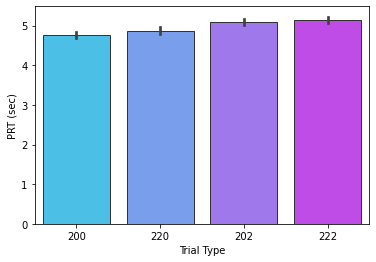

In [218]:
# visualize RXX behavior 
ax = sns.barplot(x="tt", y="PRT", data=net_rxx_prts_df,palette = 'cool',edgecolor="0.2")
ax.set_xticklabels(["200","220","202","222"] + ["400","440","404","444"]) 
ax.set_xlabel("Trial Type") 
ax.set_ylabel("PRT (sec)")

In [31]:
# Now perform same protocol for R..2 trials
n_batches = 1 
test_task_params = pp_params("rewtimes_foraging_session")
test_n_trials_per_tt = 1000
test_task_params['generation_params']['n_trials_per_tt'] = test_n_trials_per_tt # incr number of trials 
test_task_params['generation_params']['rewseqs'] = [np.array([0,1]),np.array([0,2]),np.array([0,3])] # incr number of trials 
test_task = PPSSM_FilteringTask(test_task_params,max_iter = n_batches)
trained_model.batch_size = test_task.batch_size
model_kwargs['batch_size'] = test_task.batch_size

# Run model on test trials 
s_vec, opt_s_vec, ex_pred_vec, frac_rmse_vec = [], [], [], []
with torch.no_grad():
    for i, (example_input, example_output, opt_s , opt_s_sigma2) in test_task: # loop over batches in training set 
        output_dict = trained_model.forward(example_input) # perform forward pass
        

In [32]:
# reorganize output into tt dict
concatenated_output = output_dict['readout_output'].squeeze().numpy()
concatenated_opt_s = opt_s.squeeze()

concatenated_opt_s_sigma = np.zeros((concatenated_opt_s.shape[0],concatenated_opt_s.shape[1],2))
concatenated_opt_s_sigma[:,:,0] = opt_s.squeeze()
concatenated_opt_s_sigma[:,:,1] = opt_s_sigma2.squeeze()

# Get p_leave
ix_range = range(0,concatenated_output.shape[0]+test_n_trials_per_tt,test_n_trials_per_tt)
tts = test_task.y_generator(**test_task.ppssm_params['generation_params']).keys() 
theta_readout_tts = dict()
theta_opt_tts = dict()
for i,tt in enumerate(tts):
    theta_readout_tts[tt] = concatenated_output[ix_range[i]:ix_range[i+1],:]
    theta_opt_tts[tt] = concatenated_opt_s_sigma[ix_range[i]:ix_range[i+1],:,:]
x = .75
sigma2_fixed = .5
net_p_lessthan_tts_trials = p_lessthan_x(theta_readout_tts,x,sigma2_fixed = sigma2_fixed)
opt_p_lessthan_tts_trials = p_lessthan_x(theta_opt_tts,x)

# Generate stochastic behavior
prt_lock = 8 * [3]
net_r2_prts = stochastic_prt_gen(opt_p_lessthan_tts_trials,prt_lock = prt_lock)
net_r2_prts_df = pd.DataFrame.from_dict(net_r2_prts,orient = 'index').reset_index().melt(id_vars = 'index')
net_r2_prts_df = net_r2_prts_df.drop(['variable'],axis = 'columns')
net_r2_prts_df = net_r2_prts_df.rename(columns={"index": "tt", "value": "PRT"})


Text(0.5, 1.0, 'RNN Behavior')

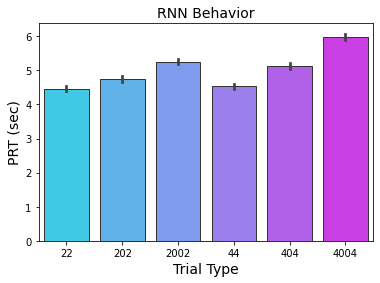

In [35]:
# visualize RXX behavior 
ax = sns.barplot(x="tt", y="PRT", data=net_r2_prts_df,palette = 'cool',edgecolor="0.2")
ax.set_xticklabels(["22","202","2002"] + ["44","404","4004"]) 
ax.set_xlabel("Trial Type",fontsize = 14) 
ax.set_ylabel("PRT (sec)",fontsize = 14) 
ax.set_title("RNN Behavior",fontsize =14)